In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tkinter import font
import pandas as pd

In [29]:
def process_monitor_to_df(file):
    f = open(file, "r")
    lines = f.readlines()
    t = 0 # timestep

    readflag = False # set true when encountering CORE, False when encountering TIME
    offset = 2

    entry_list = []

    for lid, line in enumerate(lines[offset:]):
        if line[:4] == "TIME":
            t += 1
            readflag = False
            # We dont process TIME line

        elif line[4:8] == "CORE":

            if readflag != False:
                raise ValueError("CORE line should come after TIME line. check line {} (zero-index)".format(lid+2))
            else:
                readflag = True

            table_keys = line.split()
            # we expect table of 6 columns
            assert len(table_keys) == 6, "unexpected log entries. check line {} (zero-index)".format(lid+2)

        else:
            if readflag != True:
                raise ValueError("unexpected log entries. check line {} (zero-index)".format(lid+2))
            else:
                timestep_entry = dict(zip(table_keys, line.split()))
                timestep_entry['timestep'] = t-1 # we want zero-index
                entry_list.append(timestep_entry)

    df = pd.DataFrame.from_dict(entry_list)
    df['MISSES']=df['MISSES'].apply(lambda x: x[:-1])
    df = df.rename(columns={"MISSES":"MISSES[K]"})

    int_cols = ['timestep', 'CORE', 'MISSES[K]']
    float_cols = ['IPC', 'LLC[KB]', 'MBL[MB/s]', 'MBR[MB/s]']

    for icol in int_cols:
        df[icol] = df[icol].astype('int')

    for fcol in float_cols:
        df[fcol] = df[fcol].astype('float')

    col_order = ['timestep', 'CORE', 'IPC', 'MISSES[K]', 'LLC[KB]', 'MBL[MB/s]', 'MBR[MB/s]']
    df = df[col_order]
    
    return df

In [30]:
def plot_df(df, figtitle):
    ncores=len(df.CORE.unique())
    cols_to_plot = ['IPC', 'MISSES[K]', 'LLC[KB]', 'MBL[MB/s]', 'MBR[MB/s]']

    # overlay core
    fig, axes = plt.subplots(nrows=2, ncols=len(cols_to_plot), figsize=(20,10))

    for core_id, grp_df in df.groupby(['CORE']):
        for col_id, colname in enumerate(cols_to_plot):
            ax=axes[0, col_id]
            grp_df.plot(ax=ax, x='timestep', y=colname, label=core_id, legend=None, title=colname)

    reduction_func_map = {
        'IPC': 'mean',
        'MISSES[K]': 'sum',
        'LLC[KB]': 'sum',
        'MBL[MB/s]': 'sum',
        'MBR[MB/s]': 'sum',
    }
    df_over_core = df.groupby(['timestep']).agg(reduction_func_map) #keep time dimension
    # https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
    
    for col_id, colname in enumerate(cols_to_plot):
        ax=axes[1, col_id]
        df_over_core.plot(ax=ax, y=colname, label=core_id, legend=None, title="{} over cores".format(reduction_func_map[colname]))
    
    fig.suptitle(figtitle)
    return df_over_core

In [31]:
def p(filepath, t_start=None, t_end=None):
    df = process_monitor_to_df(filepath)

    if t_start is not None:
        df=df[df.timestep >= t_start]
    
    if t_end is not None:
        df=df[df.timestep <= t_end]
    
    df_over_core = plot_df(df, filepath)
    return df, df_over_core

bert_runs = {    
    "Full": "/data2/yufenggu/bert_12llc",
    "4llc": "/data2/yufenggu/bert_4llc",
    "25mb": "/data2/yufenggu/bert_25mb",
}

rn_runs = {
    "Full": "/data2/yufenggu/resnet50_100mb",
    "4llc": "/data2/yufenggu/resnet50_4llc",
    "25mb": "/data2/yufenggu/resnet50_25mb",
}

In [32]:
def plot_runs(run_set, t_start=None, t_end=None):
    df2compare=[]
    for runlabel, rfilepath in run_set.items():
        _, df_over_core = p(rfilepath, t_start, t_end)
        df_over_core['run_id']=runlabel
        df2compare.append(df_over_core)

    cols_to_plot = ['IPC', 'MISSES[K]', 'LLC[KB]', 'MBL[MB/s]', 'MBR[MB/s]']
    fig, axes = plt.subplots(nrows=1, ncols=len(cols_to_plot), figsize=(20,5))

    for run_id, grp_df in pd.concat(df2compare).groupby(['run_id']):
        for col_id, colname in enumerate(cols_to_plot):
            ax=axes[col_id]
            grp_df.plot(ax=ax, y=colname, label=run_id, title=colname)

In [33]:
def plot_runs_filter_timestep(run_set):
    df2compare=[]
    for runlabel, rfilepath in run_set.items():
        _, df_over_core = p(rfilepath)
        df_over_core['run_id']=runlabel
        df_over_core = df_over_core[(df_over_core.index > 200) & (df_over_core.index < 700)]
        df2compare.append(df_over_core)

    cols_to_plot = ['IPC', 'MISSES[K]', 'LLC[KB]', 'MBL[MB/s]', 'MBR[MB/s]']
    fig, axes = plt.subplots(nrows=1, ncols=len(cols_to_plot), figsize=(20,3))

    for run_id, grp_df in pd.concat(df2compare).groupby(['run_id']):
        for col_id, colname in enumerate(cols_to_plot):
            ax=axes[col_id]
            grp_df.plot(ax=ax, y=colname, label=run_id, title=colname)

In [34]:
# plot_runs_filter_timestep(rn_runs)
# df, df_over_cores = p("/data2/yufenggu/resnet50_4llc")
# df.head(36)
# df.tail()

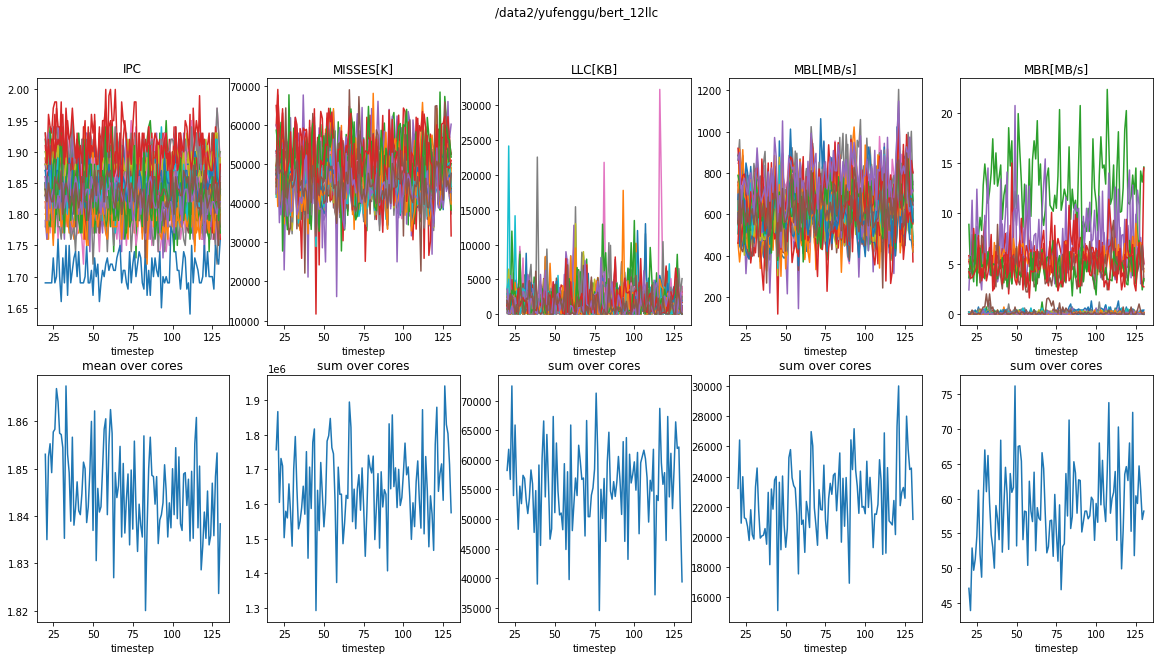

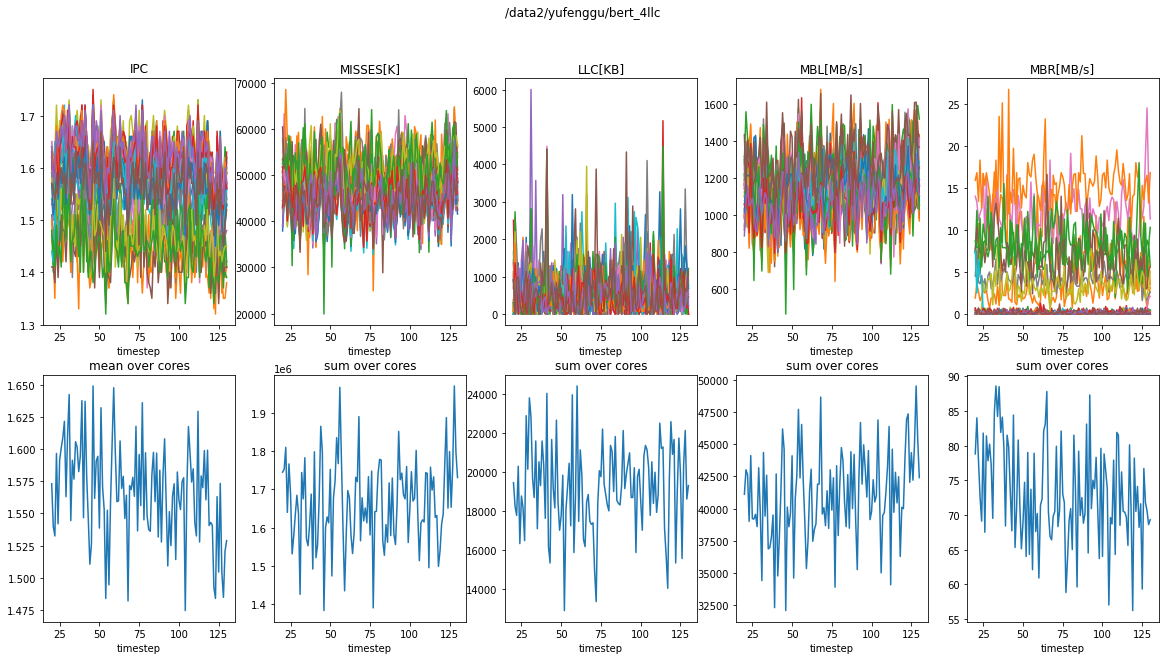

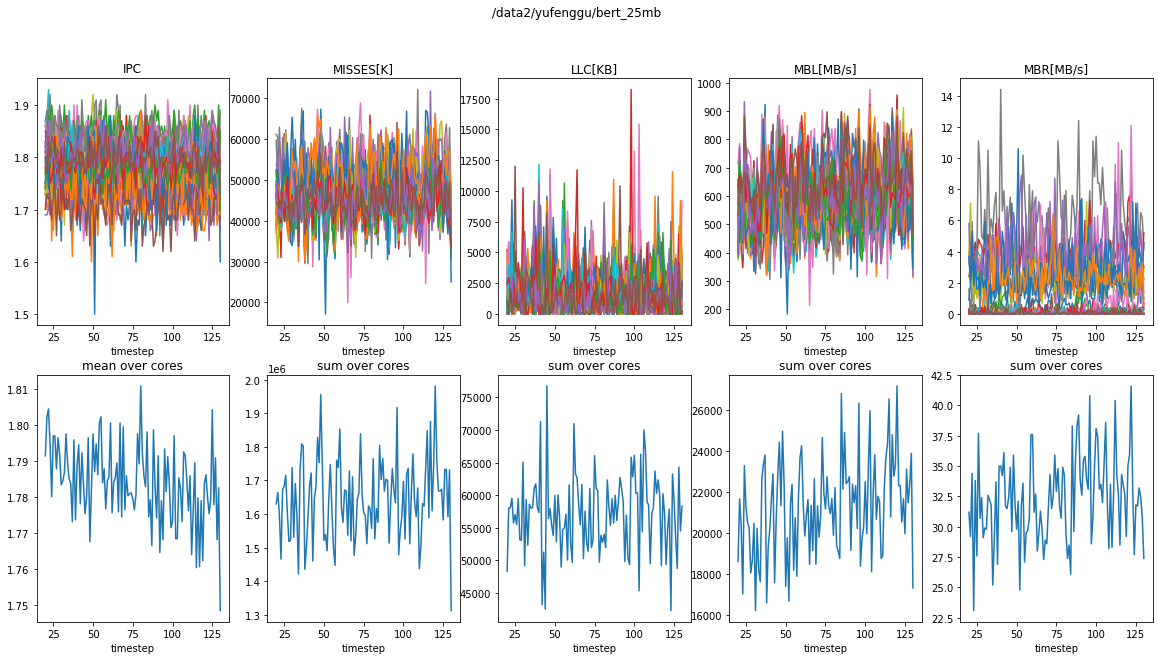

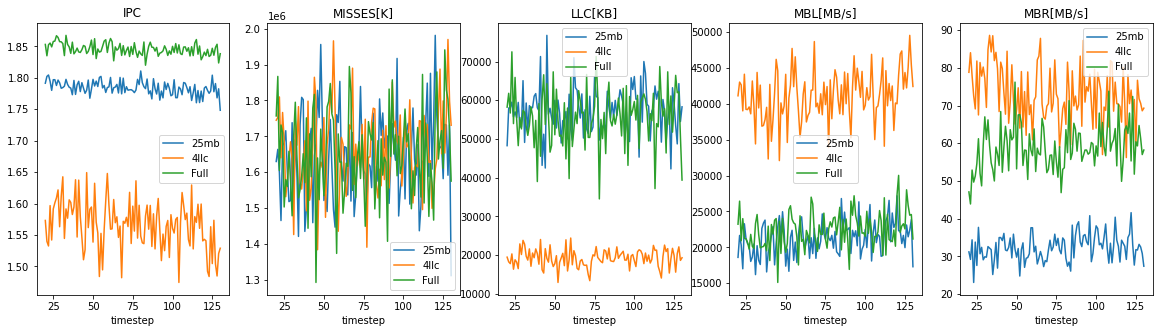

In [35]:
# plot_runs(bert_runs, t_start=20, t_end=130)
plot_runs(bert_runs)

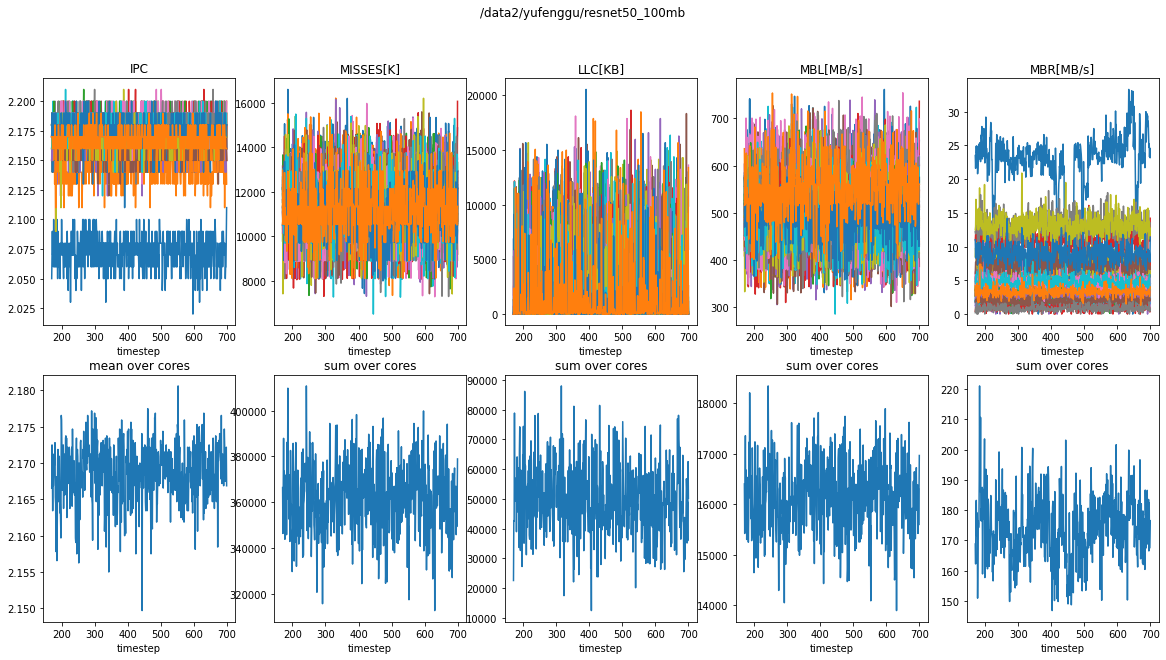

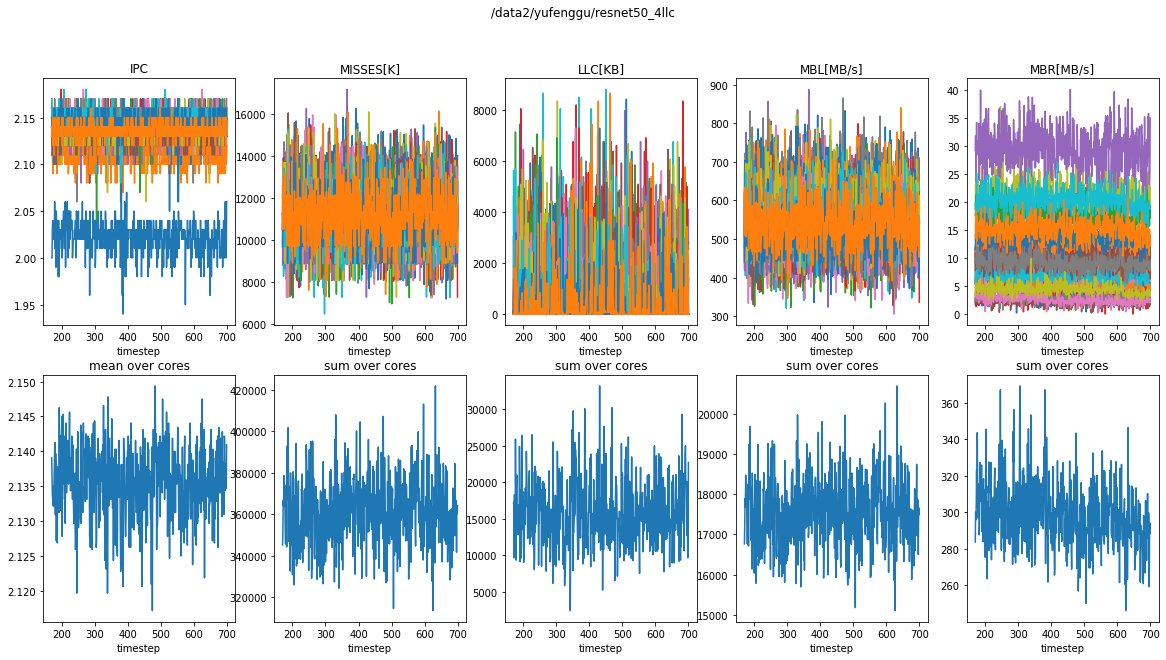

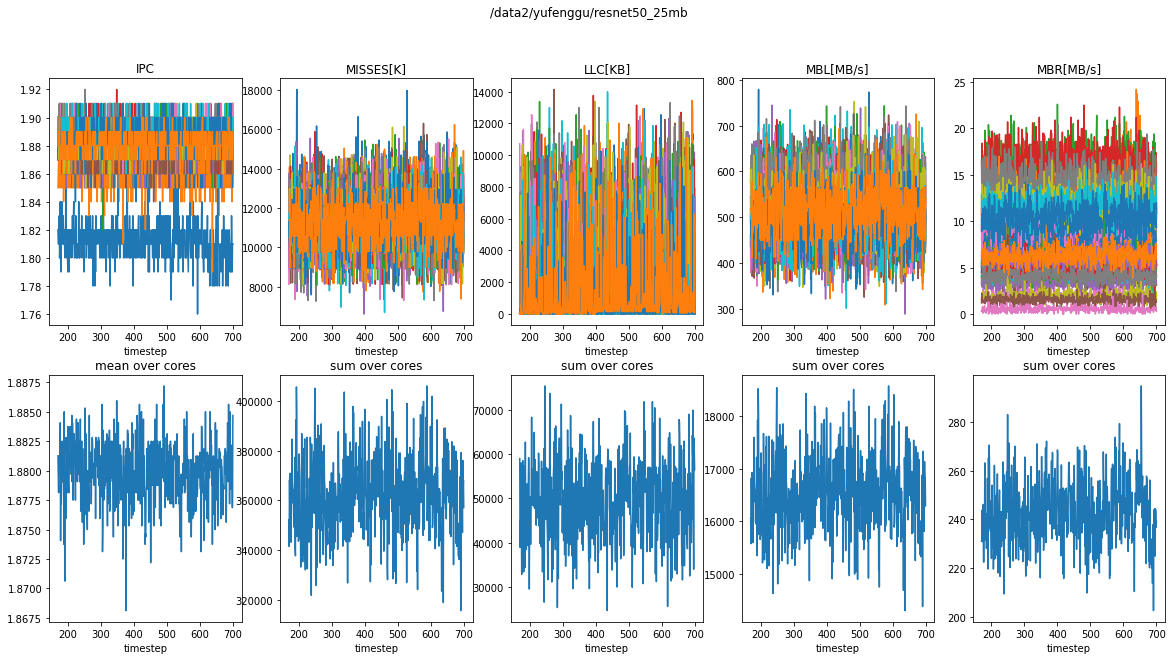

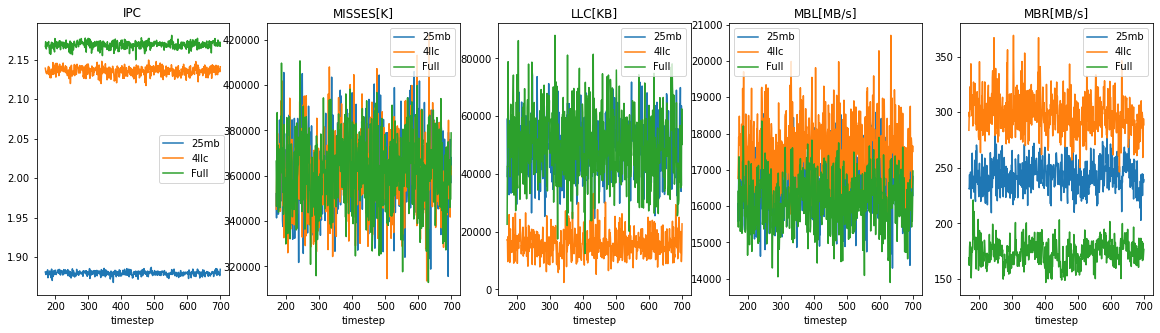

In [ ]:
# plot_runs(rn_runs, t_start=170, t_end=700)
plot_runs(rn_runs)